# *Auxiliar 1*: Semántica Vectorial
## 🌟 Modelos de Espacios Vectoriales y Recuperación de Información

**Departamento de Ciencias de la Computación, Universidad de Chile**  
**CC6205: Procesamiento de Lenguaje Natural - Otoño 2025**

---

## 🎯 Objetivos de la clase

El objetivo principal de esta clase es sumergirnos en la **clasificación de texto** dentro del campo de **Procesamiento de Lenguaje Natural (NLP)**.  
Para ello, construiremos e implementaremos varios modelos de clasificación con el fin de **predecir la categoría de noticias de la Radio Bío-Bío**.

Al finalizar la clase, deberían ser capaces de:

- Comprender la representación de texto en espacios vectoriales.
- Implementar y comparar modelos básicos de clasificación y clustering.
- Preparar y limpiar datos textuales para mejorar el rendimiento del modelo.
- Aplicar lo aprendido a futuras tareas de clasificación (incluida la Tarea 1 😉).

---

## 🔧 Contenidos clave

Vamos a repasar y aplicar los siguientes conceptos (vistos en las cátedras):

### 🛠️ Preprocesamiento de texto
- **Tokenización**: Dividir el texto en unidades manejables.
- **Stemming y lematización**: Reducir palabras a sus formas base.
- **Eliminación de *Stop Words***: Filtrar palabras comunes sin información relevante ("de", "la", "y", etc.).

### 🔍 Representación vectorial
- **Bag of Words (BoW)**: Convertir texto en vectores de frecuencia de palabras.
- **Bag of N-Grams (BoNG)**: Extensión de BoW que incluye secuencias de palabras.
- **TF-IDF (Term Frequency - Inverse Document Frequency)**: Ajusta la frecuencia de palabras según su importancia en el corpus.

### 🧠 Modelos de clasificación y clustering
- **Clasificador de Bayes ingenuo (Naive Bayes)**: Basado en probabilidades.
- **Regresión Logística**: Un modelo lineal para clasificación binaria o multiclase.
- **Clustering**: Agrupamiento de documentos sin etiquetas previas (K-means, Agglomerative).

---

## 🧱 Herramientas y librerías

Para facilitar la implementación, utilizaremos las siguientes librerías de Python:

- 🐼 **Pandas**: Manipulación y análisis de datos.
- 🔍 **Scikit-Learn**: Modelos de clasificación, clustering y preprocesamiento.
- 🧠 **Spacy**: Procesamiento avanzado de lenguaje natural.
- 🗣️ **NLTK**: Herramientas para tareas clásicas de NLP.

## Configuraciones iniciales.


En primer lugar, vamos a descargar un modelo estadístico en Español que nos servirá como tokenizador para nuestros documentos.


In [ ]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 47.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Luego de ejecutar esta celda, deben ir a Entorno de ejecución > Reiniciar entorno de ejecución. Desconozco la razón pero hay un problema de compatibilidad entre el entorno de Google Colab y las dependencias de Spacy. Cuando esté el entorno conectado nuevamente, pueden seguir con los siguientes bloques de código.


In [ ]:
import spacy

# Guardamos en la variable nlp el modelo para realizar la tokenización. Desactivamos NER, parser y tagger ya que no los necesitamos y solo consumen recursos.
nlp = spacy.load("es_core_news_sm", disable=['ner', 'parser', 'tagger'])

example = 'Este es un ejemplo del tokenizador!'
spacy_tokens = [token for token in nlp(example)]
spacy_tokens

[Este, es, un, ejemplo, del, tokenizador, !]

Ahora importamos todas las librerías que usaremos en esta auxiliar. Aún no es necesario que entiendan lo que hacen estas librerías, clases y funciones importadas ya que lo veremos ha medida que avancemos en el auxiliar.


In [ ]:
import pandas as pd
import seaborn as sns
import spacy
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from spacy.lang.es.stop_words import STOP_WORDS

## Clasificación de Texto


### ¿Qué es la clasificación de texto?

En palabras simples, la clasificación de texto es una tarea de NLP que busca clasificar el contenido de un texto en categorías pre-definidas. Antes de dar una definición formal, veamos algunos ejemplos. [Fuente](https://kavita-ganesan.com/5-real-world-examples-of-text-classification/#.YHOvqR8zbIU)


1. **Detección de SPAM**.


<center><img src="https://i1.wp.com/www.opinosis-analytics.com/wp-content/uploads/2020/08/document_classification.png?resize=872%2C436&ssl=1" width="400"></center>


2. **Sistema de ayuda a partir de información en redes sociales**.


<center><img src=https://cdn-images-1.medium.com/max/800/1*0DutkCqj51mgZ1xQp7tChA.png width="400"></center>


3. **Análisis de reviews de películas y series**.


<center><img src=https://raw.githubusercontent.com/dccuchile/CC6205/master/tutorials/recursos/limpiapiscinas.PNG width="650"></center>


🔍 Definición formal de la tarea de clasificación

Para entender mejor el desafío que enfrentamos, desglosamos la tarea de clasificación de la siguiente manera:

- **Entrada:**
  - Un documento \( d \).
  - Un conjunto fijo de clases \( C = \{c_1, c_2, ..., c_j\} \).

- **Salida:**
  - Una clase \( c \in C \) que mejor describe o categoriza el documento \( d \).

**Objetivo del modelo:** Aprender una función \( f : d \rightarrow C \) que asigne, con la mayor precisión posible, una clase a un nuevo documento no visto. Esto se logra a través del entrenamiento del modelo sobre datos etiquetados.


**Métodos para resolver la clasificación de texto.**


Hay dos clases de métodos para resolver estos problemas:

1. **Hand-coded Rules 🤙**:

   Establecemos a mano las reglas que permiten detectar las clases.

2. **Supervised Machine Learning 💻**:

   Entrenamos clasificadores a partir de muchos ejemplos de documentos que fueron etiquetados a mano. **¿El desafío de NLP?**, generar reprentaciones que nos permitan absorver la semantica desde los textos.

<center><img src=https://qph.fs.quoracdn.net/main-qimg-cf44194b2a2d7d270b09e95903c564c3 width="650"></center>

---


## Clasificación de noticias.

Cómo dijimos al comienzo, en este auxiliar crearemos un sistema que nos permita clasificar noticias de la radio biobio en 20 categorías o tópicos. Siguiendo la formalización de la task, los datos los vamos a obtener desde nuestro repositorio de github y las categorías pre-definidas son las siguientes:

```python
[
    'america-latina', 'eeuu', 'europa', 'chile', 'region-metropolitana',
    'region-del-bio-bio', 'negocios-y-empresas', 'region-de-los-lagos',
    'actualidad-economica', 'region-de-valparaiso', 'region-de-la-araucania',
    'curiosidades', 'asia', 'region-de-los-rios', 'entrevistas', 'debate',
    'mediooriente', 'viral', 'animales', 'tu-bolsillo'
]
```

Los pasos a seguir serán:

1. Descargar y procesar los datos desde el repositorio.

2. Luego, crearemos el sistema mas básico. Este consiste en transformar nuestro texto a `Bag of Words (BoW)` y luego, usar esos vectores para entrenar un clasificador. Este sistema nos puede entregar un muy buen baseline para comenzar a mejorar.

3. Evaluaremos nuestro clasificador según las métricas.

4. A continuación, veremos como mejorar aún más nuestros resultados. Para esto agregaremos muchas más técnicas vistas en cátedra, tales como el preprocesamiento de texto y probar con clasificadores aún mas sofisticados.


### Cargar los datasets

Los datos obtenidos son noticias de la radio Bío Bío. Los cargaremos directamente desde el github del curso utilizando la librería `pandas` 🐼. En cuanto al pre-procesamiento lo que haremos será dejar sólo las columnas de interés que son el título, el contenido de la noticia y la subcategoría que es la variable objetivo a predecir. Además dejaremos sólo 20 de estas categorías con 250 ejemplos en noticias en cada una para balancear los datos.


In [ ]:
# Cargamos los datos y los guardamos en un pandas dataframe.
dataset = pd.read_json(
    'https://github.com/dccuchile/CC6205/releases/download/Data/biobio_clean.bz2')

# Lo copiapos aquí por si modificamos a la variable Dataset.
dataset_r = dataset.copy(deep=True)

In [ ]:
# Vemos unos ejemplos de como se ve el Dataset original.
dataset.sample(5)


,author,author_link,title,link,category,subcategory,content,tags,embedded_links,publication_datetime
6005,Matías Vega,/lista/autores/mvega,"Nicolás Maduro libera a 40 ""presos políticos"" ...",https://www.biobiochile.cl/noticias/internacio...,internacional,america-latina,Cuarenta venezolanos acusados de delitos pol...,"[#Liberación, #Nicolás Maduro, #Presos Polític...",[],1527880080000
21542,César Vega Martínez,/lista/autores/cevega,Lentejas en Año Nuevo: así es como los romanos...,https://www.biobiochile.cl/noticias/sociedad/m...,sociedad,misterios,"Pasear con una maleta, usar ropa interior am...","[#Año Nuevo, #cotechino, #egipcios, #lentejas,...",[],1546085940000
6368,Emilio Lara,/lista/autores/elara,Gobierno holandés quiere pagarle a personas qu...,https://www.biobiochile.cl/noticias/internacio...,internacional,europa,Los trabajadores en Holanda pronto podrán au...,"[#bicileta, #Europa, #Holanda, #Medio Ambiente...",[],1529051760000
9452,Yessenia Márquez,/lista/autores/ymarquez,Denuncian que Donald Trump creó su fortuna en ...,https://www.biobiochile.cl/noticias/internacio...,internacional,eeuu,"El presidente de Estados Unidos, Donald Trum...","[#Agence France-Presse, #Donal Trump, #EE.UU.,...",[],1538521380000
12629,Gonzalo Cifuentes,/lista/autores/gcifuentes,Fiscal pide pena de muerte para cinco acusados...,https://www.biobiochile.cl/noticias/internacio...,internacional,mediooriente,El fiscal general saudí pidió la pena de mue...,"[#Internacional, #Jamal Khashoggi, #Juicio, #M...",[],1546502760000


In [ ]:
# creamos una nueva columna con la concatenación entre el titulo y el contenido.
content = dataset['title'] + '. ' + dataset['content']

# obtenemos las clases que serán nuestra variable objetivo
subcategory = dataset.subcategory

# dejamos en el dataset solo contenido de la noticia y categoria
dataset = pd.DataFrame({'content': content, 'category': subcategory})

In [ ]:
# Listado con todas las categorías originales del Dataset
subcategory.unique()

array(['region-de-valparaiso', 'region-metropolitana', 'chile',
       'region-de-los-lagos', 'region-del-maule', 'entrevistas', 'tu-voz',
       'america-latina', 'negocios-y-empresas', 'europa',
       'actualidad-economica', 'eeuu', 'africa', 'curiosidades', 'mundo',
       'asia', 'tu-bolsillo', 'mediooriente', 'debate', 'animales',
       'misterios', 'viral', 'oceania', 'consejos', 'salud',
       'region-del-bio-bio', 'region-de-la-araucania',
       'region-de-los-rios', 'region-de-magallanes',
       'region-de-antofagasta', 'region-de-ohiggins', 'region-de-atacama',
       'region-de-tarapaca', 'region-de-aysen', 'region-de-coquimbo',
       'region-de-arica-y-parinacota', 'region-de-nuble', 'videos',
       'educacion-group-nacional', 'viajes', 'fotos-ciudadanas',
       'cronicas', 'test'], dtype=object)

In [ ]:
# Veamos la cantidad de textos por categoría
dataset["category"].value_counts()

,count
category,
america-latina,4149
eeuu,2021
europa,1976
chile,1926
region-metropolitana,1699
region-del-bio-bio,1631
negocios-y-empresas,1520
region-de-los-lagos,1345
actualidad-economica,1040


In [ ]:
# Contemos la cantidad de caracteres por texto
dataset["content"].apply(lambda x: len(x)).describe()

,content
count,26413.000000
mean,2406.783856
std,1448.049946
min,168.000000
25%,1479.000000
50%,2014.000000
75%,2878.000000
max,42392.000000


In [ ]:
# Contar datos duplicados
dataset.duplicated().sum()


np.int64(147)

In [ ]:
# Contar datos faltantes NaN
dataset.isnull().sum()

,0
content,0
category,0


In [ ]:
# El número de noticias por clase lo pueden cambiar despues modificando la constante NUM_SAMPLES.
# noten que el número de noticias en el dataset original por categoría está desbalanceada.
# sample intentará sacar la mayor cantidad de ejemplos y retornará siempre, incluso si devuelve
# menos de los que le pidieron.


# Estas son las categorías que nos van a interesar
categorias_seleccionadas = [
    'america-latina', 'eeuu', 'europa', 'chile', 'region-metropolitana',
    'region-del-bio-bio', 'negocios-y-empresas', 'region-de-los-lagos',
    'actualidad-economica', 'region-de-valparaiso', 'region-de-la-araucania',
    'curiosidades', 'asia', 'region-de-los-rios', 'debate', 'entrevistas',
    'mediooriente', 'viral', 'animales', 'tu-bolsillo'
]

# filtrar solo categorias seleccionadas
dataset = dataset[dataset['category'].isin(categorias_seleccionadas)]

# fijamos el número de ejemplos para todas las categorías
NUM_SAMPLES = 250

# podrían tambien seleccionar la categoría con la menor cantidad de noticias y que todas tuvieran dicha cantidad
#NUM_SAMPLES = min(dataset.category.value_counts().values)

In [ ]:
# balancear clases
g = dataset.groupby("category")
dataset = pd.DataFrame(
    g.apply(lambda x: x.sample(NUM_SAMPLES).reset_index(drop=True))
).reset_index(drop=True)


<ipython-input-13-7cb1c13f1134>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g.apply(lambda x: x.sample(NUM_SAMPLES).reset_index(drop=True))


In [ ]:
# así quedó nuestro dataset:
dataset.category.value_counts()


,count
category,
actualidad-economica,250
america-latina,250
animales,250
asia,250
chile,250
curiosidades,250
debate,250
eeuu,250
entrevistas,250


Veamos unos cuantos ejemplos:


In [ ]:
dataset.sample(10)

,content,category
1981,Horror y depravación: lo que revela el informe...,eeuu
3231,"""Estando acá se vio un ratón aparecer"": seremi...",region-de-la-araucania
2466,Gobierno de España anuncia plan para eliminar ...,europa
1292,¿Qué pasaría con la presidencia de Estados Uni...,curiosidades
609,Perro desfigurado con ácido fue rescatado en M...,animales
1044,Tras examen psicológico: Ejército excluye a 1....,chile
2844,Tras cuatro meses de alza: carga movilizada po...,negocios-y-empresas
4217,Hombre es baleado por Carabineros en Coronel: ...,region-del-bio-bio
1093,Profesores valoran inicio de diálogo con el Mi...,chile
1773,"Estados Unidos le da ""unos días más"" a Arabia ...",eeuu


## Holdout

Ahora, el procedimiento estándar es dividir nuestros conjuntos en train y test. Este proceso es muy importante y nos permite saber que tan bien está funcionando nuestro modelo con datos que no ha visto.

Muchas veces para optimizar los hiperparámetros que componen un modelo se separa el conjunto de datos en tres:

- Training set: Datos utilizados para entrenar el modelo.
- Development set (o tuning set): Conjunto de datos que nos permite comparar diferentes hiperparámetros que probemos.
- Test set: Utilizado para comprobar el desempeño del modelo en data que no se ha visto. Es importante que este conjunto de datos no se utilice durante el ajuste de los hiperparámetros. La práctica ideal sería utilizar este conjunto de datos 1 o 2 veces para no sobre ajustar el modelo.

Un factor importante preocuparse de no solapar los conjuntos de datos. El solapamiento de los datos podría generar resultados que no representan el desempeño real del modelo, esto al considerar información repetida tanto en el conjunto de entrenamiento como en los de pruebas.


<center><img src=https://machinelearning101.readthedocs.io/en/latest/_images/0702.png width="500"></center>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.content, dataset.category, test_size=0.33, random_state=42
)

print(f"Cantidad de noticias en el conjunto de entrenamiento: {X_train.shape}")
print(f"Cantidad de noticias en el conjunto de test: {X_test.shape}")


Cantidad de noticias en el conjunto de entrenamiento: (3350,)
Cantidad de noticias en el conjunto de test: (1650,)


### Nuestro primer sistema de clasificación

Ahora que tenemos cargado el dataset, podemos implementar nuestro clasificador!

Para esto, usaremos 3 herramientas fundamentales de scikit-learn: un `pipeline`, `CountVectorizer` y `MultinomialNB`.

#### Pipeline

<center><img src="https://miro.medium.com/max/1400/1*3CUgNaoTUG3eg_BOFkN-YA.jpeg" width="350"></center>

Un [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) es la definición de los procesos que llevará a cabo el sistema que creemos. Nos permite tener unificados todos los procesos a la vez que simplifica el código de nuestro sistema. De esta forma, un Pipeline encapsulará una seguidilla de pasos en su modelo, para ejecutarlos secuencialmente.

¿Cuales son los beneficios de generar un pipeline? 🤔:

1. Encapsula todo el proceso: La creación de un pipeline encapsula todo el preceso de entrenamiento, permitiendo entrenar todo el modelo llamando solo a un fit.
2. Selección conjunta de parámetros: Se puede realizar una GridSearch de los parámetros de todos los estimadores del pipeline al mismo tiempo.
3. Evita fugas de datos, generando un proceso en el que se evitan errores estadisticos.
4. El uso de Pipelines permite que su trabajo sea mucho más reproducible.

Para el caso que veremos en esta Auxiliar, el pipeline será:

    Dataset -> Bag of Words -> NaiveBayes Clf

#### Bag of Words y CountVectorizer 🎒

¿Qué era Bag of Words?

Es un modelo en donde transformamos cada una de las oraciones de nuestro dataset en vectores. Cada vector contiene una columna por cada palabra / **token** del vocabulario. Al procesar el dataset, cada oración es mapeada a un vector que cuenta las apariciones de cada una de sus tokens.

Referencia: [BoW en wikipedia](https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras)

**Un pequeño ejemplo**

Supongamos que nuestro tokenizador solo separa por espacios.

    - Doc1 : 'I love dogs'
    - Doc2: 'I hate dogs and knitting.
    - Doc3: 'Knitting is my hobby and my passion.

El bag of words quedaría:

|      | I   | love | hate | dogs | and | knitting | is  | my  | hobby | passion |
| ---- | --- | ---- | ---- | ---- | --- | -------- | --- | --- | ----- | ------- |
| Doc1 | 1   | 1    | 0    | 1    | 0   | 0        | 0   | 0   | 0     | 0       |
| Doc2 | 1   | 0    | 1    | 1    | 1   | 1        | 0   | 0   | 0     | 0       |
| Doc3 | 0   | 0    | 0    | 0    | 1   | 1        | 1   | 2   | 1     | 1       |

`CountVectorizer` es la clase de `scikit` que transformará nuestro texto a Bag of Words. Fijense que es tremendamente útil tenerla dentro de un pipeline ya que fija en un comienzo el vocabulario que tendrá el Bag of Words, evitando discordancias entre los vectores del conjunto de entrenamiento y el de prueba.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer()

# Documentos de ejemplo relacionados con noticias
documentos = ['el gobierno anuncia nuevas reformas económicas',
              'el equipo local gana el campeonato nacional',
              'se descubren avances importantes en la inteligencia artificial']

# Convertimos los documentos en una representación Bag of Words
conteo_palabras = vectorizer.fit_transform(documentos)

# Mostramos el resultado en formato tabla
pd.DataFrame(conteo_palabras.toarray(),
             columns=vectorizer.get_feature_names_out())

,anuncia,artificial,avances,campeonato,descubren,económicas,el,en,equipo,gana,gobierno,importantes,inteligencia,la,local,nacional,nuevas,reformas,se
0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,1,0,0,2,0,1,1,0,0,0,0,1,1,0,0,0
2,0,1,1,0,1,0,0,1,0,0,0,1,1,1,0,0,0,0,1


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))

conteo_palabras = vectorizer.fit_transform(documentos)
pd.DataFrame(conteo_palabras.toarray(),
             columns=vectorizer.get_feature_names_out())

,anuncia,anuncia nuevas,artificial,avances,avances importantes,campeonato,campeonato nacional,descubren,descubren avances,económicas,...,la inteligencia,local,local gana,nacional,nuevas,nuevas reformas,reformas,reformas económicas,se,se descubren
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,1,1,1,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,1


**Todo espectacular pero... ¿Esto no tiene problemas?:**

Al considerar solamente una bolsa con palabras, ignoramos la semantica y el orden de las palabras. Esto nos quita contexto, perdiendo gran información en los textos.

#### **Algoritmo de Naive Bayes**

Es uno de los algoritmos más simples y efectivos para la clasificación de texto. Se basa en el teorema de Bayes utilizando una suposición de independencia de los features para poder simplificar el computo. Es así como el nombre se descompone de la siguiente forma:

Naive (ingenuo): La presencia de un feature es independiente de la presencia de otro. Ejemplo, asumir que la probabilidad de que una palabra aparezca en un documento no depende de las palabras cercanas. Se dice ingenuo ya que en ejemplos es reales no es correcto asumir esto.

Bayes: Proviene del teorema de Bayes.

**Teorema de Bayes**

En términos generales, la fórmula del teorema es como sigue:

$$p(H|D) = \frac{p(D|H) * p(H)}{p(D)}$$

$p(H|D)$: Probabilidad de que la hipótesis H sea cierta dados los datos D.

$p(H)$: Probabilidad de que la hipótesis H sea cierta, independiente de los datos. Esto es conocido como probabilidad a priori.

$p(D)$: Probabilidad de los datos.

$p(D|H)$: Probabilidad de los datos D dado que la hipótesis H era cierta.

Luego se busca la hipótesis o clase en nuestro caso que tenga la probabilidad más alta.

Vamos a explicar el clásificador de Bayes enfocados en nuestro problema:

Escojamos un noticia, por ejemplo $d$ = `'7 tips que necesitas saber para que tus mascotas...'`

Y nuestro conjunto de clases $C$=`{america-latina, eeuu, chile, ..., virales, animales}`

Podemos usar el teorema de bayes para calcular la probabilidad de que una noticia pertenezca a una de nuestras clases como:

$$p( c_i | d) = \frac{p(d | c_i) * p(c_i)}{p(d)}$$

Lo que puede ser escrito en nuestro ejemplo como:

p( `america-latina` | `7 tips...`) = p( `7 tips...` | `america-latina`) \* p(`america-latina`) / p(`7 tips...`)

**Clasificación**

Por lo tanto, la clase de cada noticia quedará representada simplemente como la máxima probabilidad que obtengamos al calcular bayes para todas las clases $c_i$, lo que puede ser representado como un argmax:

$$\underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i|d)$$

Ahora, despejemos un poco la ecuación:

1. Primero, veamos el denominador p(d) no nos entrega nada de información ya que se calcula contando la cantidad de apariciones de esa noticia d dividido en el total, pero como todas las noticias son distintas entonces la probabilidad será siempre la misma.

$$\underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i|d) = \underset{c_i \in C}{\operatorname{argmax}} \:\: \dfrac{p(d|c_i)p(c)}{p(d)} = \underset{c_i \in C}{\operatorname{argmax}} \:\: p(d | c_i) * p(c_i)$$

2. Por otra parte, $p(c_i)$ es la cantidad de veces que encontramos la clase $c_i$ en nuestro conjunto de datos, pero como nuestras clases están balanceadas, $p(c_i) = 250/250*20 = 1 / 20$ para todas las clases. Nota que este balance no siempre ocurre así que dejaremos por ahora ese término dentro de nuestra ecuación.

Ahora ¿Cómo calculamos $p(d | c_i)$?:

1. Primero, separamos el documento por tokens. Menos mal que ya lo habíamos hecho conviertiendo nuestros documentos BoW...

$$p(d | c_i) = p(x_1, x_2, x_n | c_i)$$

2. Ahora, asumimos que las probabilidades de que cada una de las palabras pertenezca a la clase c_i es independiente de cualquier otra, es decir:

$$ p(x_1, x_2, x_n | c_i) = p(x_1 | c_i) _ p(x_2 | c_i) _ ... \* p(x_n | c_i)$$

Observen que ahora, dado que asumimos esto, el orden de las palabras no importa. Otro punto mas a favor de usar BoW.


**Entrenamiento 🥋**

Y aquí viene la parte del entrenamiento del modelo: para calcular $p(x | c_i)$ simplemente contamos la cantidad de veces que aparece esa palabra en los documentos de entrenamiento de la clase $c_i$. O sea:

$$p(x | c_i) = \frac{count(x_j, c_i)}{\sum_{x_j \in Vocab} count(x, c_i)}$$

Juntando lo anterior, nuestro problema ahora se transforma a :

$$c = \underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i) \times \prod_{x_j \in d} P(x_j | c_i)$$

Sin embargo, estas probabilidades son extremadamente pequeñas cuando usamos vectores Bag of Words grandes. Imaginen un vocabulario de 100.000 palabras. Además, multiplicar muchas probabilidades pequeñas lleva a **desbordamiento numérico** ❌😥.

Por eso, transformamos el producto en una **suma de logaritmos** (recuerda: \( \log(a \times b) = \log(a) + \log(b) \)):

$$ c = \underset{c_i \in C}{\operatorname{argmax}} \:\: \log(p(c_i)) + \sum_{x_j \in d} \log(p(x_j | c_i))$$

Y con eso, ya tenemos definido como va a funcionar nuestro clasificador. Si bien, existen muchos mas clasificadores, este ya es lo suficientemente potente como para lograr muy buenos resultados.

**Bkn... ¿pero si quisiera calcular la probabilidad la probabilidad que tiene un documento de ser de la clase $i$? 🙄**

Para calcular la probabilidad debemos obtener $P(d)$ del problema, el que se define como:

$$p(d) = \sum_{c_i \in C} p(d|c_i)p(c_i) = \sum_{c_i \in C} p(x_1,x_2, ..., x_n|c_i)*p(c_i)$$
$$= \sum_{c_i \in C} (p(x_1|c_i)*p(x_2|c_i) *...* \text{p}(x_n|c_i)*p(c_i))$$
$$= \sum_{c_i \in C} (\prod_{x_j \in d} p(x_j|c_i)*p(c_i))$$

De lo anterior, el contenido de la sumatoria es conocido, por lo que nos quedaría sumar solamente todos los valores para cada una de las clases.


## Smoothing 🧈 (smooth like butter..)

Imaginemos que entrenamos un conjunto de datos utilizando el modelo de Naive Bayes, ¿Qué sucede si las palabras a predecir no se encuentran en el vocabulario de entrenamiento?, La respuesta directa a la pregunta señalada es que si no modificamos el modelo, este, entregará una probabilidad ($p(x | c_i)$) igual a 0 para dicha palabra, ya qué le sería imposible determinar una clase.

Una solución a esta indeseable situación es utilizar **Laplace Smoothing**, quien suaviza las probabilidades agregandole un "seudo-conteo" $\alpha$ a cada uno de los conteos, y luego los normaliza.

$$p(x | c_i)=\dfrac{\alpha + count(x, c_i)}{V\alpha + \sum_{i=1}^V count(x, c_i)}$$

Utilizar Laplace Smoothing reducirá la varianza vista por la imposibilidad de clasificación, pero nos aleja del estimador provocando un sesgo en la predicción 😡. Hay que recordar que:

- Clasificadores insesgados (en general con alta varianza) podrian sobreajustar los datos de entrenamiento.
- Si el suavizado es muy grando (o sea el alfa), se podra genera un underfit en el entrenamiento.


**Discusión:**


    ¿ Comó podriamos escoger el mejor alpha para el modelo de Naive Bayes?


## ¿Entonces como podría programar Naive? (Resumen)

1. Generar un vocabulario basado en el corpus de entrenamiento.
2. La etapa de `fit` vendra dada por el calculo de $P(c_i)$ y $P(w_j|c_i)$ en base al corpus de entrenamiento.
3. Para la etapa `predict` tendremos que simplemente calcular la probabilidades de los documentos no vistos en base a los de entrenamiento, para luego a traves de argmax determinar a que clase pertenece.


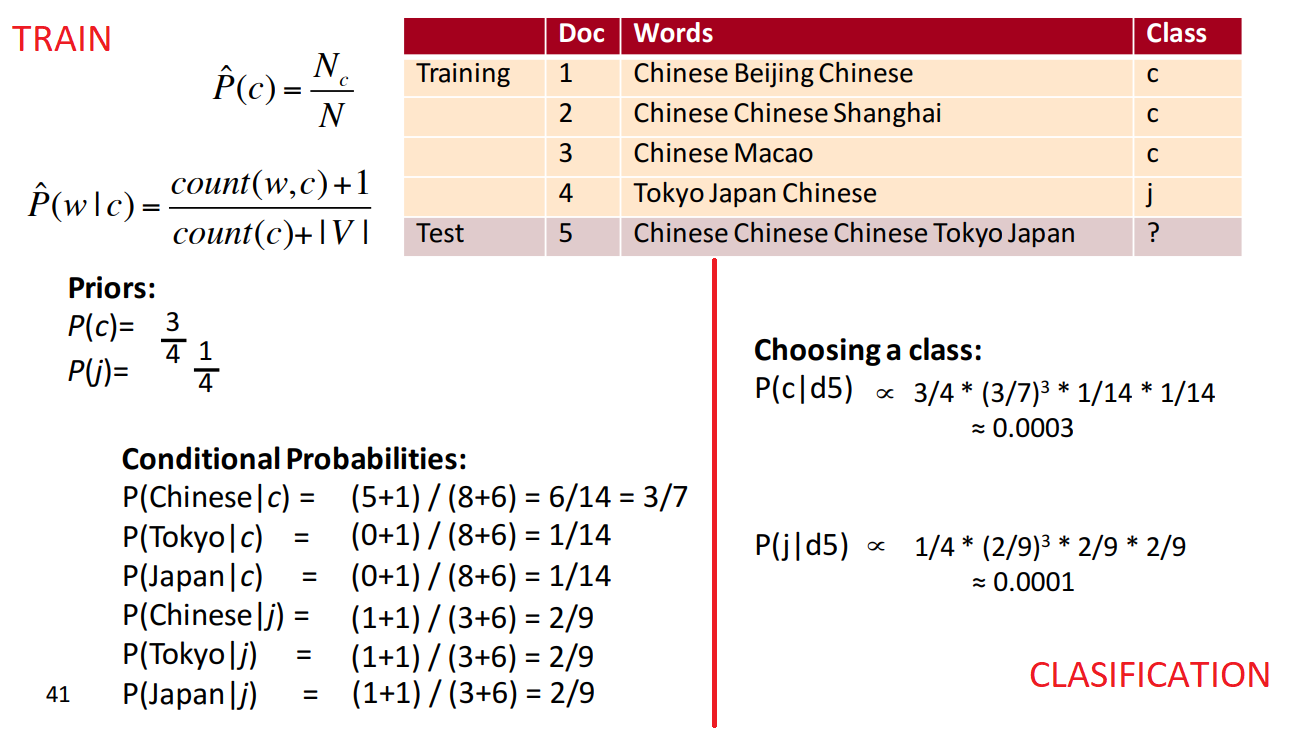


Notar que la probabilidad para los casos de ejemplo vendrian dada por:

$$P(c|d5) = \dfrac{0.0003}{0.003+0.0001} = 0.75$$

$$P(j|d5) = \dfrac{0.0001}{0.003+0.0001} = 0.25$$


---

#### Creemos el clasificador 🧪

**Primero, definimos el pipeline**


In [ ]:
# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer()

# Definimos el clasificador que usaremos.
clf = MultinomialNB()

# Creamos el pipeline
text_clf = Pipeline([('vect', vectorizer),  # Paso 1 del pipeline
                     ('clf', clf)]         # Paso 2 del pipeline
                    )

**Luego, lo entrenamos**


In [ ]:
X_train

,content
1522,Real Academia Española tajante por el uso del ...
835,40% de norcoreanos sufre escasez de alimentos ...
358,Presidente de El Salvador asegura que pandilla...
138,"IPC tuvo variación mensual de 0,6% en mayo, ma..."
299,CIDH muestra preocupación por situación de mig...
...,...
4426,Justicia condena a Help por error de diagnósti...
466,OPS reporta aumento significativo de casos de ...
3092,Formalizan a sargento de Carabineros (r) acusa...
3772,"Piden justicia para Nicole, joven lesbiana tor..."


In [ ]:
# Entrenamos nuestro pipeline
text_clf.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

**Y predecimos**


In [ ]:
y_pred = text_clf.predict(X_test)


**Veamos como nos fue:**


In [ ]:
# algunos ejemplos:
pd.DataFrame({'content': X_test, 'category': y_test,
             'predicted category': y_pred}).sample(5)

,content,category,predicted category
3347,El crudo relato sobre víctimas de sectario ins...,region-de-los-lagos,debate
3103,Apoderados acusan que alumnos de escuela rural...,region-de-la-araucania,region-del-bio-bio
677,Dudas de expertos: ¿Cómo fue que una ballena d...,animales,animales
33,"PIB creció un 1,5% en 2017 completando cuatrie...",actualidad-economica,actualidad-economica
3825,Persona trans perdió su ojo izquierdo tras agr...,region-de-valparaiso,region-metropolitana


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[45  1  1  1  9  2  0  2  3  3  0 10  0  0  0  0  0  1 16  0]
 [ 0 69  0  2  0  0  6  3  1  0  1  0  0  0  0  0  0  0  2  1]
 [ 0  0 59  2  0  4  8  0  0  1  0  0  0  0  0  0  0  0  0 16]
 [ 0  1  0 51  0  1  7 10  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 2  2  0  0 62  0  2  2 10  0  0  3  3  1  0  1  1  4  3  0]
 [ 0  0  4  2  0 37 20  1  0  3  0  0  0  0  0  0  0  0  1  9]
 [ 1  0  5  2  0  5 63  3  1  3  0  1  0  0  0  0  0  0  0  8]
 [ 0  2  1  8  0  1  7 51  0  1  6  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  0  3  0 67  1  2  1  0  0  0  0  1  0  4  0]
 [ 0  4  0  2  0  1  6  4  0 59  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  2  0  2 71  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  3  3  1  1  2  0  0 48  0  0  0  0  1  1 20  0]
 [ 1  0  0  0 16  0  0  0  2  0  0  2 44  2  4  4  6  5  1  0]
 [ 1  1  0  0  9  0  2  0  1  1  0  3  0 46  3  1  2  2  1  0]
 [ 0  0  1  0  4  0  1  0  0  0  0  1  0  2 58  3  2  6  2  0]
 [ 0  0  0  0 10  1  1  0  4  1  0  2  0  0  2 56  1  7

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

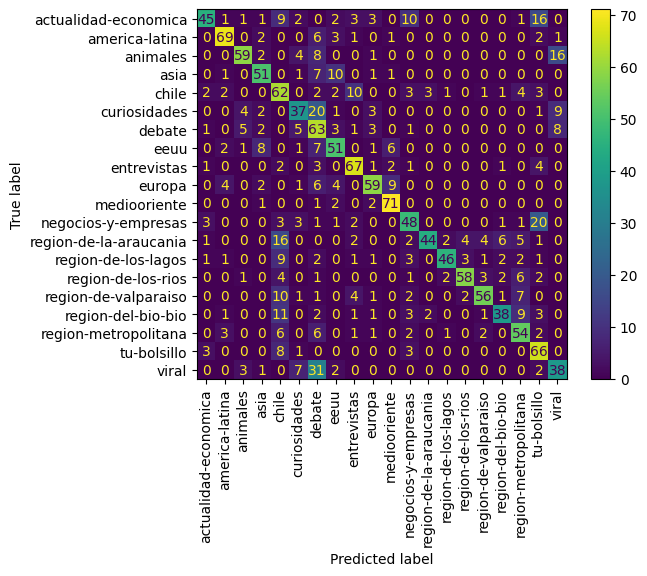

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    xticks_rotation="vertical");

#### Métricas de Evaluación

Las métricas definen un puntaje de evaluación que indica que tal le fue al sistema. Hay muchas formas distintas de medir su rendimiento. Entre estas, tenemos:

- `precision`: El número de documentos de una clase clasificados correctamente dividido por el número de documentos totales clasificados como esa clase. Precision es una buena medida para determinar, cuando los costes de los falsos positivos son altos.

- `recall`: El número de documentos de una clase clasificados correctamente dividido por el número de los documentos que se deberían haber clasificado como esa clase (número de documentos reales de esa clase). Lo utilizamos cuando tiene un alto coste la detección falsos negativos.

- `f1-score` : Es la media armónica entre los anteriores.

- `accuracy` : La cantidad de documentos clasificados correctamente versus todos los documentos

Por otra parte, tenemos dos formas de ver dichas métricas agrupadas:

- `Macroaveraging`: Se computan las métricas por cada clase y luego de promedia.

- `Microaveraging`: Se recolectan las clasificaciones por cada clase, se computa la tabla de contingencia (todos los elementos clasificados) y se evalua. Representa un Macroaveraging ponderado por el número de miembros de una clase.


In [ ]:
# usando el classification report:
print(classification_report(y_test, y_pred))


                        precision    recall  f1-score   support

  actualidad-economica       0.79      0.48      0.60        94
        america-latina       0.82      0.81      0.82        85
              animales       0.80      0.66      0.72        90
                  asia       0.71      0.71      0.71        72
                 chile       0.44      0.65      0.53        96
          curiosidades       0.59      0.48      0.53        77
                debate       0.38      0.68      0.49        92
                  eeuu       0.63      0.66      0.65        77
           entrevistas       0.72      0.82      0.77        82
                europa       0.76      0.69      0.72        85
          mediooriente       0.79      0.92      0.85        77
   negocios-y-empresas       0.61      0.58      0.59        83
region-de-la-araucania       0.90      0.51      0.65        87
   region-de-los-lagos       0.88      0.63      0.74        73
    region-de-los-rios       0.87      

**Tokens más importantes por clase**

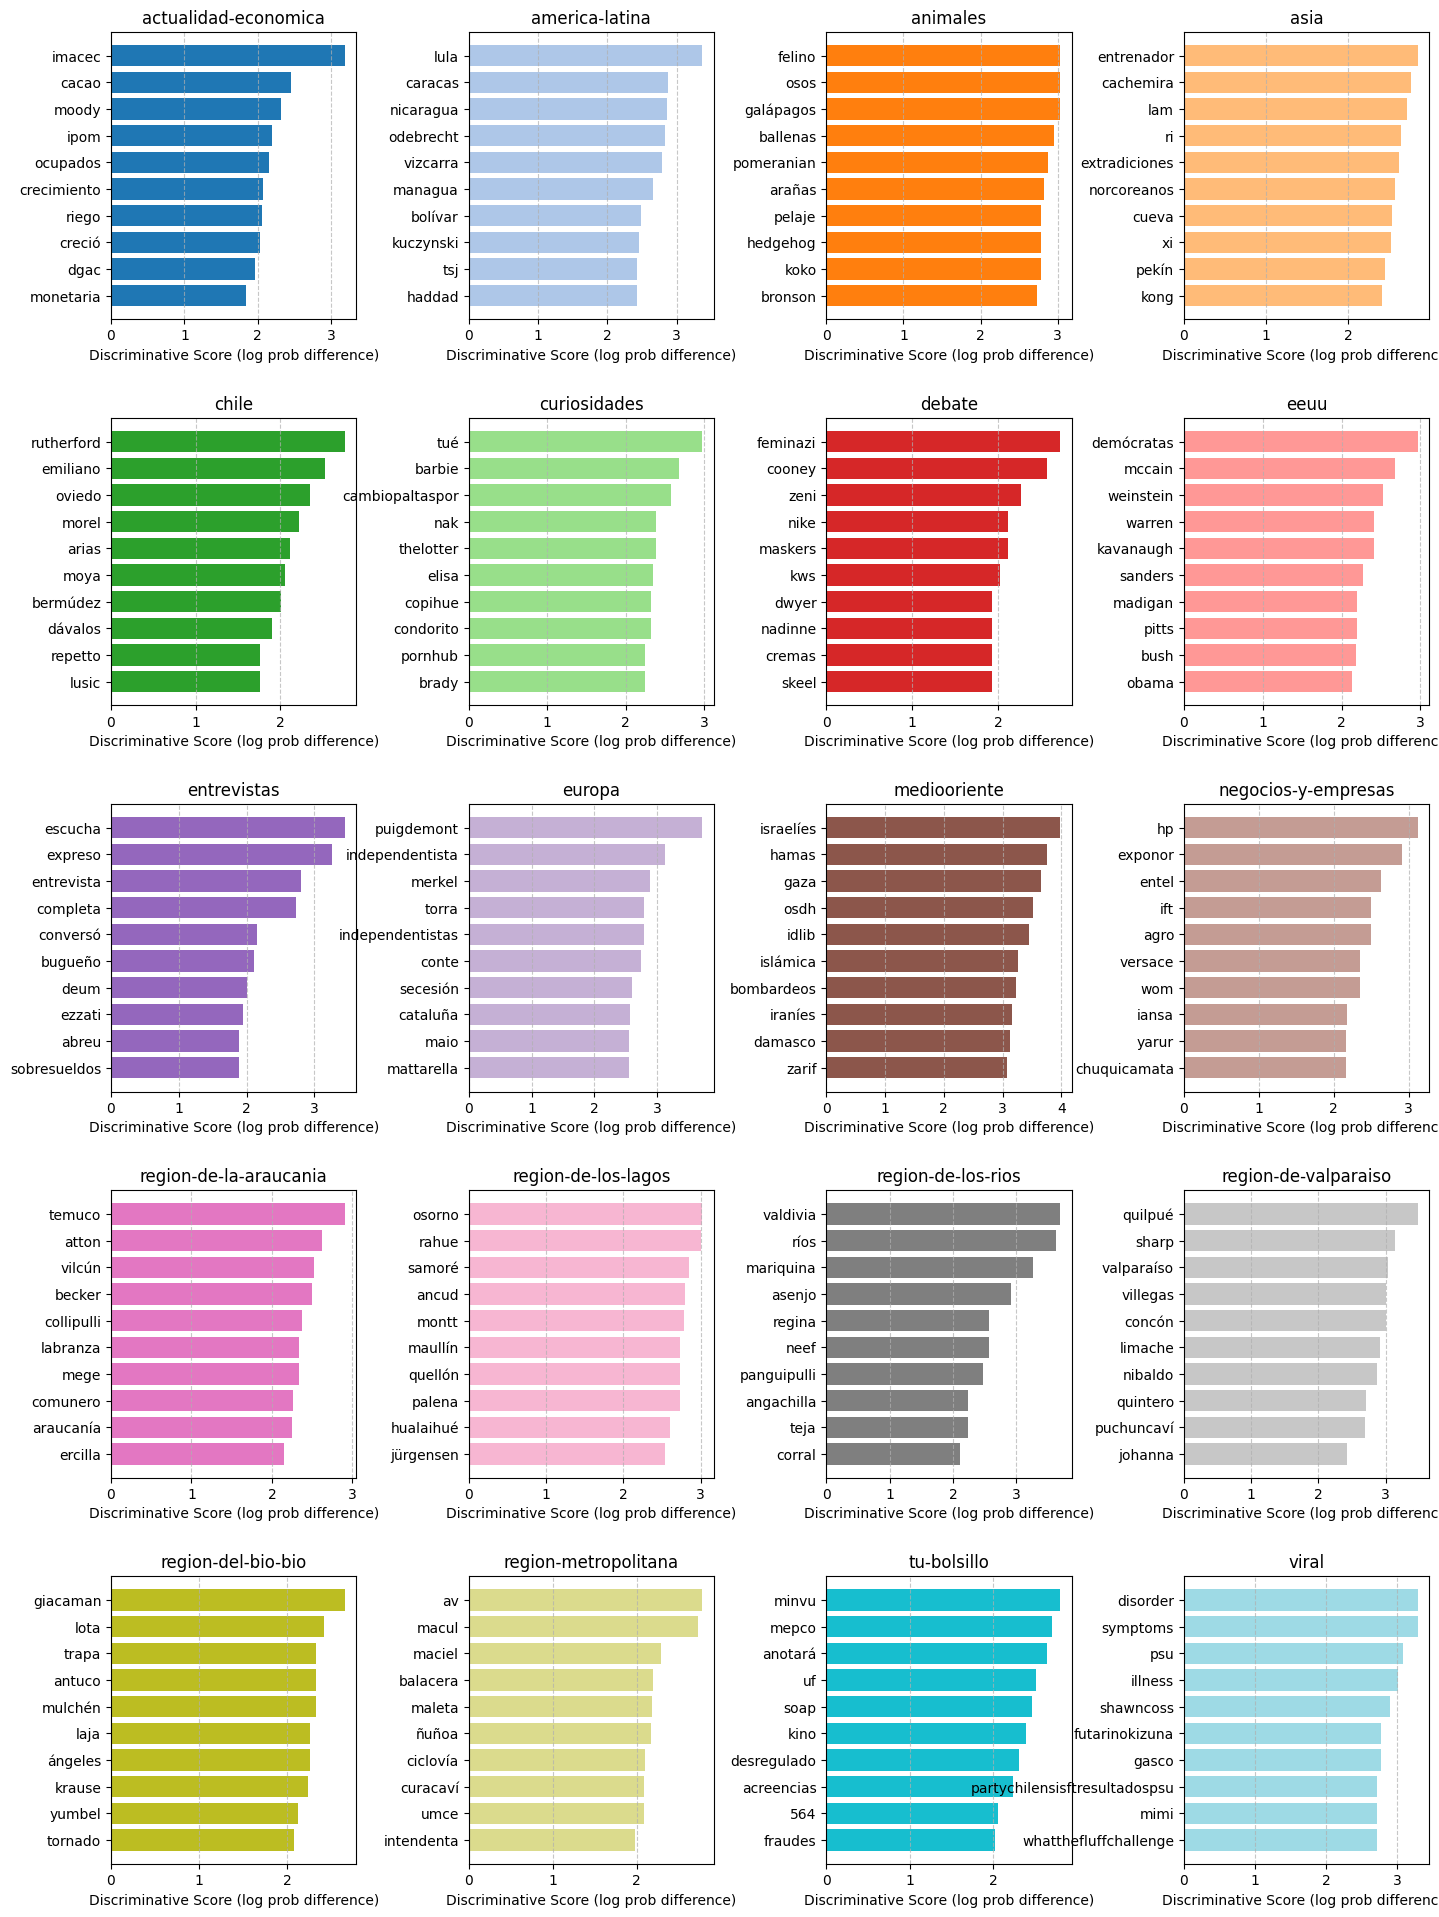

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract model components
class_labels = text_clf.named_steps['clf'].classes_
feature_names = text_clf.named_steps['vect'].get_feature_names_out()
log_probs = text_clf.named_steps['clf'].feature_log_prob_

top_k = 10  # Number of top unique words per class
colors = plt.cm.tab20.colors

# Set up subplots: 5 rows x 4 columns for 20 classes
fig, axes = plt.subplots(5, 4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# For each class, find words that contribute most exclusively to that class
for i, class_label in enumerate(class_labels):
    # Get log probabilities for this class and all others
    class_log_probs = log_probs[i]
    other_log_probs = np.delete(log_probs, i, axis=0)  # All other classes

    # Compute how much each word is more associated with this class
    max_other_probs = np.max(other_log_probs, axis=0)
    discriminative_scores = class_log_probs - max_other_probs

    # Get top k discriminative words for this class
    top_features_idx = np.argsort(discriminative_scores)[-top_k:]
    top_features = [feature_names[j] for j in top_features_idx]
    top_scores = discriminative_scores[top_features_idx]

    # Determine row and column for the subplot (5 rows, 4 columns)
    row = i // 4
    col = i % 4

    # Plot bar chart for this class
    axes[row, col].barh(top_features, top_scores, color=colors[i % len(colors)])
    axes[row, col].set_xlabel('Discriminative Score (log prob difference)')
    axes[row, col].set_title(f'{class_label}')
    axes[row, col].grid(axis='x', linestyle='--', alpha=0.7)

# Display the full plot
plt.show()


#### Ejecutemos algunas consultas!


In [ ]:
text_clf.predict([
    ("En puerto montt se encontró un perrito, que aparentemente,"
     "habría consumido drogas de alto calibre. Producto de esto,"
     "se ponostíca que padecerá severa caña durante varios dias.")
])

array(['region-de-los-lagos'], dtype='<U22')

In [ ]:
text_clf.predict(
    ["kim jong un será el próximo candidato a ministro de educación."])

array(['asia'], dtype='<U22')

In [ ]:
text_clf.predict(
    [
        (
            "El banco mundial presentó para chile un decrecimiento"
            "económico de 92% y una inflación de 8239832983289%."
        )
    ]
)


array(['actualidad-economica'], dtype='<U22')

---

Se ven bastante buenos los resultados. ¿Pero, podremos mejorarlos?

### Preprocesamiento del texto

En clases vimos que habían varias técnicas que permiter preprocesar los textos.
Es decir, cómo hacemos el proceso de tokenización (separación de las palabras).

Alguna de las técnicas son:

- Eliminación de Stopwords
- Stemming
- Lematización

Existen otros preprocesadores que agregan información a las oraciones, tales como aquellos que indican negaciones.

A continuación, describiremos con mas detalle cada uno de estas técnicas.


#### Tokenizar ➗

¿Qué era tokenizar?

Es el proceso de convertir una secuencia de carácteres (por ejemplo, una oración) en una secuencia de valores distintos entre si llamados tokens.

Referencia: [Tokenización en wikipedia](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)


**spaCy y el objeto nlp**

`nlp` es el objeto que nos permite usar e interactuar con la librería [`spacy`](https://spacy.io/).
Esta librería incluye variadas herramientras, tales como tokenizar, lematizar, descartar stopwords, entre otras (para este auxiliar, solo utilizaremos las mencionadas). El objeto nlp lo instanciamos en la sección de imports.

Para usarla, simplemente se le pasa el texto como parámetro, como veremos en el siguiente ejemplo:


In [ ]:
DOC = "Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas"

tokens = []
for word in nlp(DOC):
    tokens.append(word)

tokens


[Los,
 pingüinos,
 son,
 las,
 únicas,
 aves,
 vivientes,
 no,
 voladoras,
 adaptadas,
 al,
 buceo,
 propulsado,
 por,
 las,
 alas]

**Observación**: Para este auxiliar usaremos `List Comprehension`, otra forma de hacer un for un poco mas reducida.
Una muy buena referencia de esto [aquí](https://www.programiz.com/python-programming/list-comprehension).

La operación anterior usando esta sintáxis quedaría como:


In [ ]:
tokens = [word for word in nlp(DOC)]
tokens

[Los,
 pingüinos,
 son,
 las,
 únicas,
 aves,
 vivientes,
 no,
 voladoras,
 adaptadas,
 al,
 buceo,
 propulsado,
 por,
 las,
 alas]

#### Stopwords 🛑

¿Qué eran las stopwords?

Las Stopwords son palabras muy comunes en nuestro lenguaje y que por lo tanto, no aportan mucha información. Existen múltiples listas de stopwords para muchos idiomas y la aplicación de estas variará caso a caso.

Referencias: [Stopwords en Wikipedia](https://en.wikipedia.org/wiki/Stop_words)

En este caso, utilizaremos las stopwords inlcuidas en la librería spaCy en español


In [ ]:
from spacy.lang.es.stop_words import STOP_WORDS

In [ ]:
print(len(STOP_WORDS))
print(list(STOP_WORDS)[0:20])


521
['menudo', 'podriais', 'poner', 'todo', 'grandes', 'pueda', 'vuestro', 'ni', 'todas', 'grande', 'dicho', 'cuándo', 'pocos', 'otro', 'cuál', 'sabes', 'que', 'existe', 'da', 'qeu']


In [ ]:
[token for token in tokens if str(token).lower() not in STOP_WORDS]

[pingüinos,
 únicas,
 aves,
 vivientes,
 voladoras,
 adaptadas,
 buceo,
 propulsado,
 alas]

#### Stemming 🔪

¿Qué era el stemming?

Son un conjunto de métodos enfocados en reducir cada palabra a su raiz. De cierta manera se parece a la lematización, pero los resultados (las raíces) no tienen por qué ser palabras de un idioma.

Referencia: [Stemming en Wikipedia](https://en.wikipedia.org/wiki/Stemming)

**Ejemplos: **

| word    | stem of the word |
| ------- | ---------------- |
| working | work             |
| worked  | work             |
| works   | work             |

**nltk**

En este caso, utilizaremos la segunda librería de herramientas de nlp: [`nltk`](https://www.nltk.org/). Esta provee una buena herramienta para hacer stemming en español : `SnowballStemmer`


In [ ]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish")
DOC = "Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas"
tokens = [word for word in nlp(DOC)]
stemmed_doc = [stemmer.stem(str(token)) for token in tokens]
print(stemmed_doc)


['los', 'pingüin', 'son', 'las', 'unic', 'aves', 'vivient', 'no', 'volador', 'adapt', 'al', 'buce', 'propuls', 'por', 'las', 'alas']


#### Lematización 🙀

¿Qué era lematización?

Es el proceso de transformar cada token a su lema, el cual es la palabra base sin ningún tipo de flexión o alteración como las conjugaciones. El lema no es otra cosa que la forma que tienen las palabras cuando las buscas en el diccionario.

Referencia: [Lematización en wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

Refernecia: [Flexión en las palabras](<https://es.wikipedia.org/wiki/Flexi%C3%B3n_(ling%C3%BC%C3%ADstica)>)

**Ejemplos**

| word    | lemma |
| ------- | ----- |
| dije    | decir |
| guapas  | guapo |
| mesitas | mesa  |

**Lematizar el texto**

Al igual que la tokenización, utilizaremos `scpaCy` (a través del objeto `nlp`) para lematizar el contenido.


In [ ]:
nlp = spacy.load("es_core_news_sm")

DOC = "Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas"
lemmatized_content = [word.lemma_ for word in nlp(DOC)]
print(lemmatized_content)


['el', 'pingüino', 'ser', 'el', 'único', 'ave', 'viviente', 'no', 'voladora', 'adaptado', 'al', 'buceo', 'propulsado', 'por', 'el', 'ala']


#### Otros métodos de preprocesamiento

In [ ]:
# Convertir a minúsculas
DOC = "Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas"
DOC.lower()


'los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas'

In [ ]:
# Eliminar tildes con unicode
!pip3 install unidecode

from unidecode import unidecode
DOC = "Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas"

unidecode(DOC)

'Los pinguinos son las unicas aves vivientes no voladoras adaptadas al buceo propulsado por las alas'

In [ ]:
# Eliminar puntuación con expresiones regulares

import re
DOC = "Los pingüinos... son las únicas aves vivientes, no voladoras, adaptadas al buceo. ¡Propulsado por las alas!"

re.sub(r'[^\w\s]', '', DOC)

'Los pingüinos son las únicas aves vivientes no voladoras adaptadas al buceo Propulsado por las alas'

**Discusión:**

    ¿Cuál es mejor técnica?
    ¿Debo ocuparlas todas?


### Sistema de clasificación con preprocesamiento

Para agregar los tokenizadores en el sistema, creamos funciones que que cada documento de forma individual usando nuestro preprocesador favorito. Luego, `CountVectorizer` se encargará de usar estas funciones sobre todo el dataset.


#### Tokenizadores para CountVectorizer


In [ ]:
from concurrent.futures import ThreadPoolExecutor
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.stem import SnowballStemmer

# Cargamos SpaCy solo una vez
nlp = spacy.load("es_core_news_sm")
stemmer = SnowballStemmer('spanish')

# Función auxiliar para procesar un solo documento
def process_doc(doc, func):
    return func(doc)

# Tokenizador básico
def tokenizer(doc):
    return [token.orth_ for token in nlp(doc)]

# Tokenizador con stopwords removidas
def tokenizer_with_stopwords(doc):
    return [token.orth_ for token in nlp(doc) if token.lower_ not in STOP_WORDS]

# Tokenizador con lematización
def tokenizer_with_lemmatization(doc):
    return [token.lemma_ for token in nlp(doc)]

# Tokenizador con stemming
def tokenizer_with_stemming(doc):
    return [stemmer.stem(token.orth_) for token in nlp(doc)]

# Función general para procesar múltiples documentos en paralelo
def parallel_tokenizer(docs, tokenizer_func, max_workers=10):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(lambda doc: process_doc(doc, tokenizer_func), docs))
    return results


#### Creamos nuestro clasificador

**Definimos el pipeline**


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Seleccionamos el tokenizador a usar
TOKENIZER = lambda doc: parallel_tokenizer([doc], tokenizer_with_stemming)[0]

# Definimos el vectorizador para convertir el texto a BoW
vectorizer_2 = CountVectorizer(
    analyzer='word',
    tokenizer=TOKENIZER,
    ngram_range=(1, 1)
)

# Definimos el clasificador que usaremos
clf_2 = MultinomialNB()

# Creamos el pipeline
text_clf_2 = Pipeline([
    ('vect', vectorizer_2),
    ('clf', clf_2)
])

**Entrenamos nuestro pipeline y predecimos**


In [ ]:
# text_clf_2.fit(X_train, y_train)
# y_pred = text_clf_2.predict(X_test)

**Evaluamos**


In [ ]:
# ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred,
#     xticks_rotation="vertical");


In [ ]:
# # usando el classification report:
# print(classification_report(y_test, y_pred))


#### Pregunta abierta: ¿Por qué no mejoran los resultados?

## Clasificación usando Regresión Logísitica con N-gramas

No profundizaremos en este clasificador, mas del hecho de que se "supone" que debería tener mejor rendimiento que el de bayes.

Referencia: [Regresión Logística](https://en.wikipedia.org/wiki/Logistic_regression)


Los n-gramas son conjuntos de n-tokens seguidos entre si. La idea de usar esto es que además, capturemos conceptos.

Por ejemplo, si usamos 2-gramas sobre `'Hoy día comí lentejas'`, esta quedaría como:

```python
['hoy dia', 'día comí', 'comí lentejas']
```

`CountVectorizer` tiene la opción para poner n-gramas del tamaño que tu quieras, y además incluir mas pequeños. Todo esto se define en el parámetro `ngram_range`. Este recibe una tupla con los rangos del n-grama mas pequeño y el mas grande. Por ejemplo, para (1,2), la oración anterior quedaría:

```python
['hoy', 'día', 'comí', 'lentejas', 'hoy dia', 'día comí', 'comí lentejas']
```

Nota que esto incrementa el tamaño de los vectores de Bag of words y por lo tanto, del entrenamiento y de la predicción.


In [ ]:
from sklearn.pipeline import Pipeline

# Definimos el vectorizador para convertir el texto a BoW
vectorizer = CountVectorizer()

# Ahora definimos regresión logística como clasificador.
log_mod = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)

# Generamos un Pipeline con el vectorizador y el clasificador
log_pipe = Pipeline([('vect', vectorizer), ('clf', log_mod)])

# Entrenar
log_pipe.fit(X_train, y_train)

# Predecir
y_pred = log_pipe.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


**Evaluamos**


In [ ]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred))


[[56  0  1  0  5  2  1  0  0  2  0 16  0  0  0  2  1  2  6  0]
 [ 1 67  1  1  1  1  3  3  0  1  0  1  0  0  0  0  0  0  2  3]
 [ 0  0 73  0  0  6  0  0  0  1  0  0  0  0  0  0  0  0  0 10]
 [ 1  1  1 52  1  4  2  5  0  0  2  1  0  0  0  1  0  0  0  1]
 [ 6  1  0  0 63  1  1  1  1  0  0  3  4  2  1  1  2  8  1  0]
 [ 1  0  6  1  1 39 10  2  0  5  0  0  0  0  0  1  0  2  1  8]
 [ 1  0  6  1  2 15 45  1  1  2  0  2  0  0  0  0  0  1  1 14]
 [ 0  5  1  9  0  3  4 47  0  1  6  1  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  1  0 75  0  1  1  0  0  0  0  1  1  0  0]
 [ 1  0  1  3  0  3  3  3  0 64  4  0  0  0  0  0  0  1  0  2]
 [ 0  0  0  2  0  2  0  3  0  4 66  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  4  1  0  1  0  0  0 61  0  0  0  0  2  2  4  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  1 80  2  0  0  0  2  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  5  0 62  1  0  2  1  1  0]
 [ 0  0  1  0  1  0  0  0  0  0  0  1  0  2 71  1  0  3  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  1  2  4  0 74  1  1

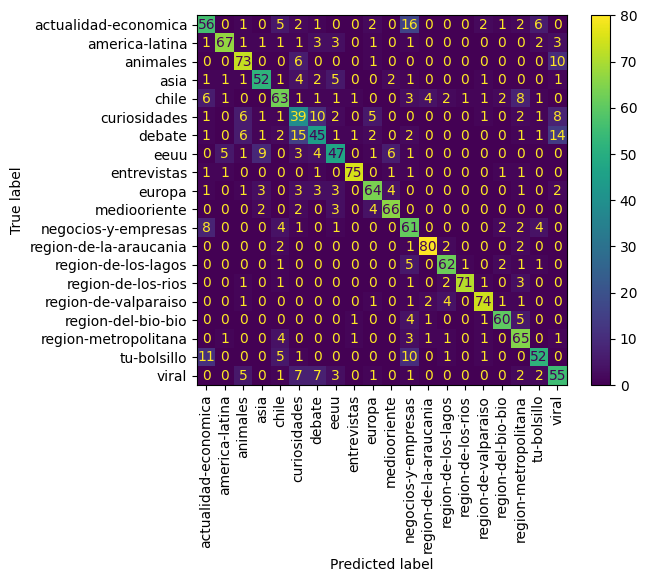

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    xticks_rotation="vertical");

In [ ]:
# usando el classification report:
print(classification_report(y_test, y_pred))


                        precision    recall  f1-score   support

  actualidad-economica       0.64      0.60      0.62        94
        america-latina       0.88      0.79      0.83        85
              animales       0.75      0.81      0.78        90
                  asia       0.75      0.72      0.74        72
                 chile       0.69      0.66      0.67        96
          curiosidades       0.46      0.51      0.48        77
                debate       0.58      0.49      0.53        92
                  eeuu       0.68      0.61      0.64        77
           entrevistas       0.95      0.91      0.93        82
                europa       0.78      0.75      0.77        85
          mediooriente       0.84      0.86      0.85        77
   negocios-y-empresas       0.54      0.73      0.63        83
region-de-la-araucania       0.91      0.92      0.91        87
   region-de-los-lagos       0.84      0.85      0.84        73
    region-de-los-rios       0.97      

**Tokens más importantes por clase**

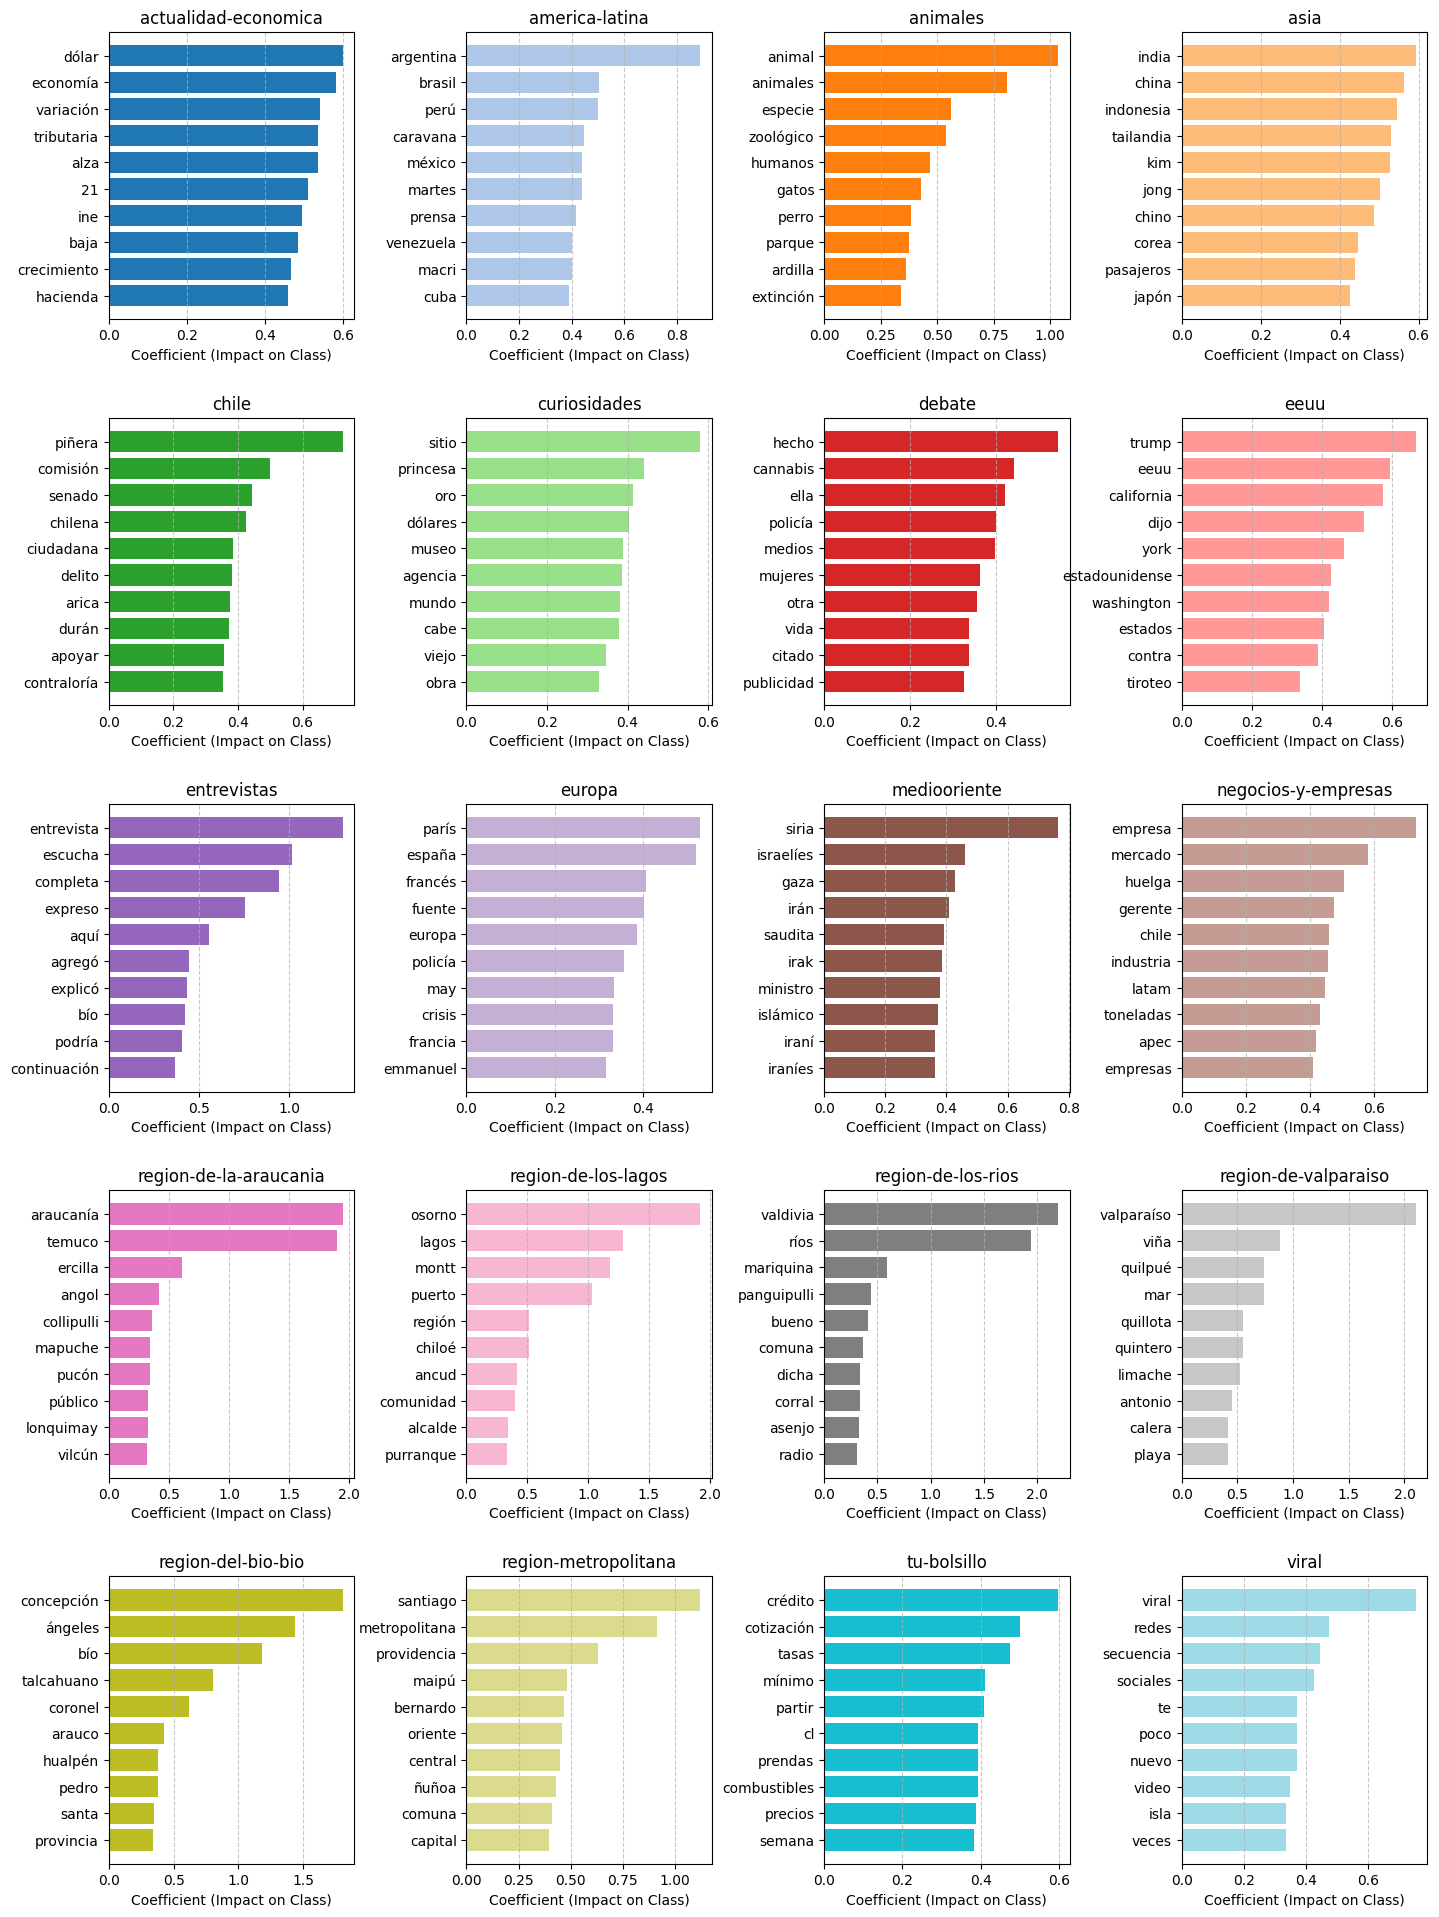

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract components from the trained pipeline
class_labels = log_pipe.named_steps['clf'].classes_
feature_names = log_pipe.named_steps['vect'].get_feature_names_out()
coefficients = log_pipe.named_steps['clf'].coef_

top_k = 10  # Number of top influential words per class
colors = plt.cm.tab20.colors

# Create subplots: one per class, arranged in a 5x4 grid
fig, axes = plt.subplots(5, 4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# For each class, find the words with the highest coefficients
for i, class_label in enumerate(class_labels):
    # Get coefficients for this class
    class_coefs = coefficients[i]

    # Get indices of the top K positive coefficients
    top_features_idx = np.argsort(class_coefs)[-top_k:]

    # Get the corresponding words and coefficients
    top_features = [feature_names[j] for j in top_features_idx]
    top_values = class_coefs[top_features_idx]

    # Determine subplot position (5 rows, 4 columns)
    row = i // 4
    col = i % 4

    # Plot the bar chart for this class
    axes[row, col].barh(top_features, top_values, color=colors[i % len(colors)])
    axes[row, col].set_xlabel('Coefficient (Impact on Class)')
    axes[row, col].set_title(f'{class_label}')
    axes[row, col].grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## Clustering

**🎯 Objetivo del estudio**

Probaremos distintas representaciones y métodos para agrupar las noticias del dataset y compararemos los resultados.

✅ Representaciones de texto (sparse):

* Bag of Words (BoW)
*   TF-IDF
*   Bag of N-Grams (BoNG)

✅ Algoritmos de clustering:

*   K-Means
*   Agglomerative Clustering (Jerárquico)
*   DBSCAN

✅ Métricas a comparar:

*   Silhouette Score
*   Homogeneity Score (si tenemos etiquetas reales)
*   Número de clusters obtenidos (para DBSCAN)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

X = X_train
y = y_train

Processing Representation: BoW
  - Vectorization completed for BoW
  - TruncatedSVD dimensionality reduction completed for BoW
    - Processing Clustering: K-Means
      - Clustering completed for K-Means with 20 clusters
      - Silhouette Score: 0.005, Homogeneity Score: 0.106
    - Processing Clustering: DBSCAN


<ipython-input-63-8205909bfe38>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


      - Clustering completed for DBSCAN with 12 clusters
      - Not enough clusters or DBSCAN detected noise (-1), setting scores to NaN
Processing Representation: TF-IDF
  - Vectorization completed for TF-IDF
  - TruncatedSVD dimensionality reduction completed for TF-IDF
    - Processing Clustering: K-Means
      - Clustering completed for K-Means with 20 clusters
      - Silhouette Score: 0.003, Homogeneity Score: 0.301
    - Processing Clustering: DBSCAN
      - Clustering completed for DBSCAN with 1 clusters
      - Not enough clusters or DBSCAN detected noise (-1), setting scores to NaN
Processing Representation: BoNG
  - Vectorization completed for BoNG
  - TruncatedSVD dimensionality reduction completed for BoNG
    - Processing Clustering: K-Means
      - Clustering completed for K-Means with 20 clusters
      - Silhouette Score: -0.015, Homogeneity Score: 0.100
    - Processing Clustering: DBSCAN
      - Clustering completed for DBSCAN with 16 clusters
      - Not enough clus

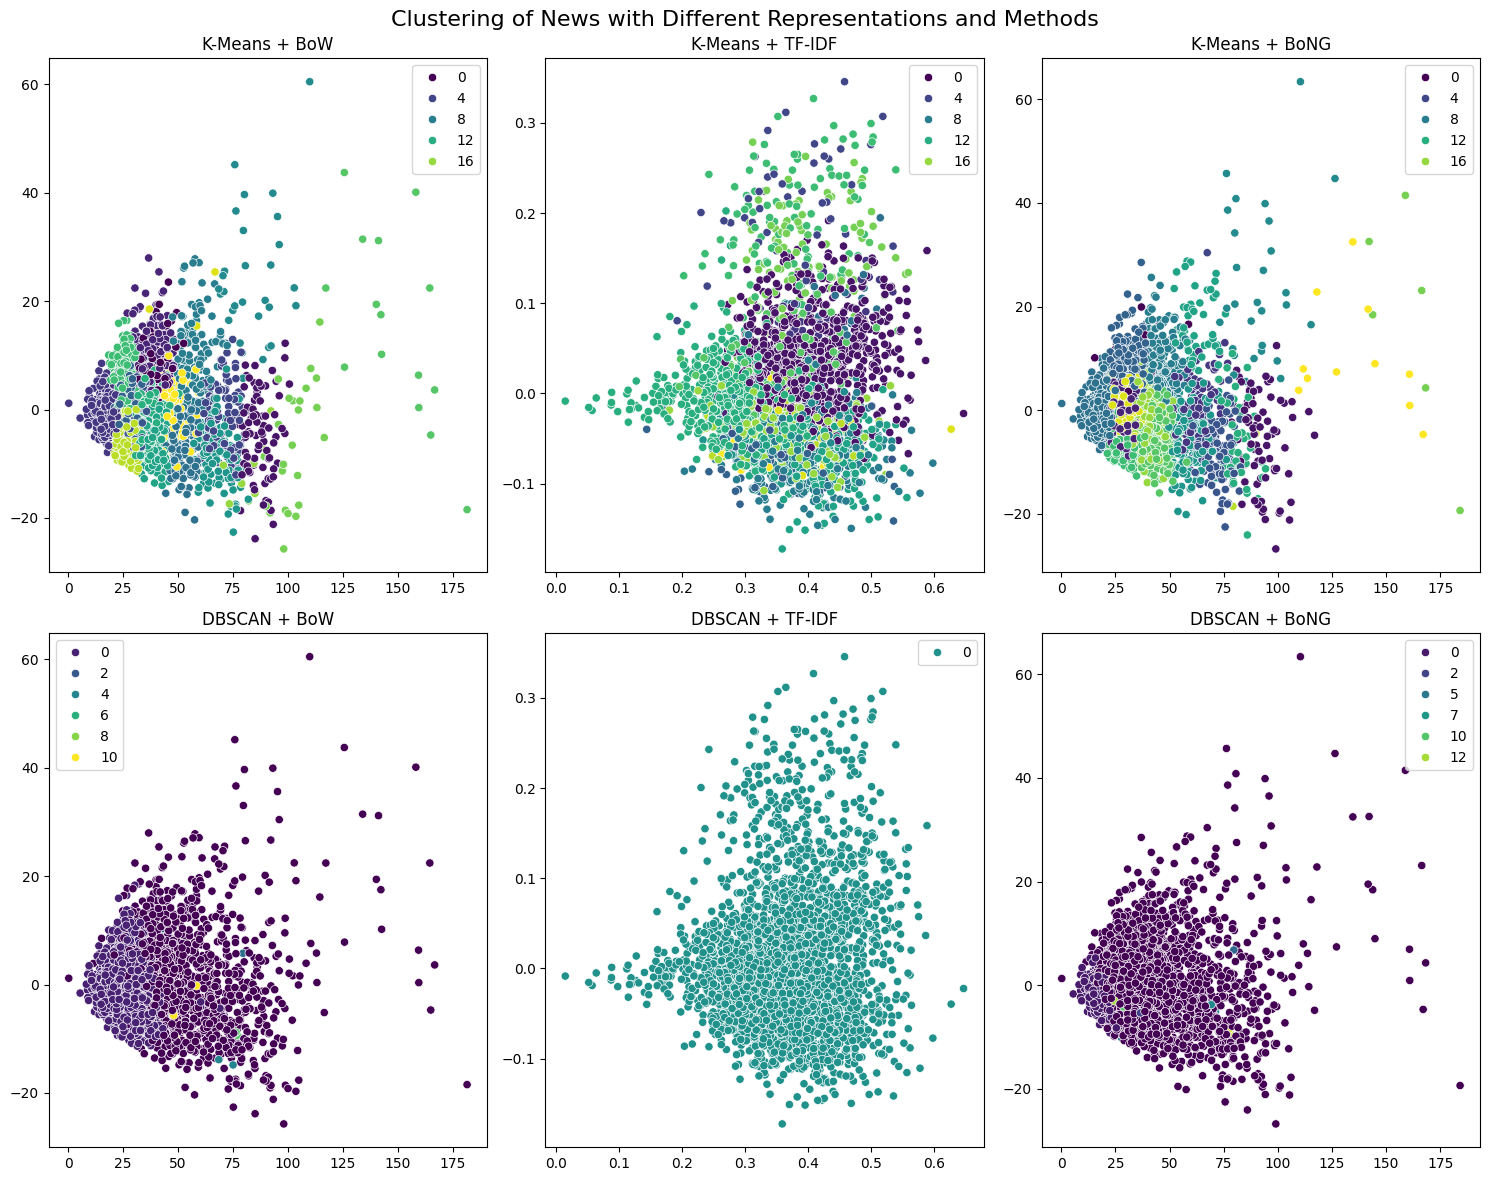

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Define the vectorizers
representations = {
    "BoW": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
    "BoNG": CountVectorizer(ngram_range=(1, 2))
}

# Define the clustering methods
clustering_methods = {
    "K-Means": KMeans(n_clusters=20, random_state=42),
    "DBSCAN": DBSCAN(eps=25, min_samples=2)
}

# DataFrame to store metrics
results_df = pd.DataFrame(columns=[
    "Clustering", "Representation", "Silhouette", "Homogeneity", "Number of Clusters", "Error"
])

# Create figure for plots
fig, axes = plt.subplots(len(clustering_methods), len(representations), figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

# Iterate over clustering methods and representations
for col, (rep_name, vectorizer) in enumerate(representations.items()):
    print(f"Processing Representation: {rep_name}")  # Print the representation being processed

    # Vectorize the text
    X_vec = vectorizer.fit_transform(X)
    print(f"  - Vectorization completed for {rep_name}")

    # Reduce dimensionality using TruncatedSVD (faster than t-SNE)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_tsne = svd.fit_transform(X_vec)
    print(f"  - TruncatedSVD dimensionality reduction completed for {rep_name}")

    for row, (clust_name, cluster_model) in enumerate(clustering_methods.items()):
        print(f"    - Processing Clustering: {clust_name}")  # Print the clustering method being processed
        try:
            # Perform clustering
            clusters = cluster_model.fit_predict(X_vec)
            print(f"      - Clustering completed for {clust_name} with {len(set(clusters))} clusters")

            # Evaluate clustering results
            if len(set(clusters)) > 1 and -1 not in set(clusters):
                silhouette = silhouette_score(X_vec, clusters)
                homogeneity = homogeneity_score(y, clusters)
                print(f"      - Silhouette Score: {silhouette:.3f}, Homogeneity Score: {homogeneity:.3f}")
            else:
                silhouette = homogeneity = np.nan
                print(f"      - Not enough clusters or DBSCAN detected noise (-1), setting scores to NaN")

            # Store the metrics
            new_row = pd.DataFrame([{
                "Clustering": clust_name,
                "Representation": rep_name,
                "Silhouette": round(silhouette, 3),
                "Homogeneity": round(homogeneity, 3),
                "Number of Clusters": len(set(clusters)),
                "Error": None
            }])
            results_df = pd.concat([results_df, new_row], ignore_index=True)

            # Visualize the clusters
            ax = axes[row, col]
            sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis', ax=ax)
            ax.set_title(f"{clust_name} + {rep_name}")
            # ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

        except Exception as e:
            # Handle errors and log them
            print(f"      - Error occurred during clustering with {clust_name}: {str(e)}")
            new_row = pd.DataFrame([{
                "Clustering": clust_name,
                "Representation": rep_name,
                "Silhouette": np.nan,
                "Homogeneity": np.nan,
                "Number of Clusters": np.nan,
                "Error": str(e)
            }])
            results_df = pd.concat([results_df, new_row], ignore_index=True)

            # Plot the error message in the grid
            ax = axes[row, col]
            ax.set_title(f"{clust_name} + {rep_name}")
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', fontsize=12, color='red')

# Set general title
plt.suptitle("Clustering of News with Different Representations and Methods", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Mostramos resultados finales
results_df

,Clustering,Representation,Silhouette,Homogeneity,Number of Clusters,Error
0,K-Means,BoW,0.005,0.106,20,None
1,DBSCAN,BoW,NaN,NaN,10,None
2,K-Means,TF-IDF,0.003,0.301,20,None
3,DBSCAN,TF-IDF,NaN,NaN,1,None
4,K-Means,BoNG,-0.015,0.100,20,None
5,DBSCAN,BoNG,NaN,NaN,8,None


## Créditos

Todas las noticias extraidas pertenecen a [Bio Bío Chile](https://www.biobiochile.cl/), los cuales gentilmente licencian todo su material a través de la [licencia Creative Commons (CC-BY-NC)](https://creativecommons.org/licenses/by-nc/2.0/cl/)


## Referencias

Github del curso:

- https://github.com/dccuchile/CC6205

Slides:

- https://web.stanford.edu/~jurafsky/slp3/slides/7_NB.pdf

Análisis de sentimientos como clasificación de texto:

- https://affectivetweets.cms.waikato.ac.nz/benchmark/

Algunos Recursos útiles

- [Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
- [Scikit-learn Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)
- [Spacy Tutorial](https://www.datacamp.com/community/blog/spacy-cheatsheet)
- [NLTK Cheat sheet](http://sapir.psych.wisc.edu/programming_for_psychologists/cheat_sheets/Text-Analysis-with-NLTK-Cheatsheet.pdf)
